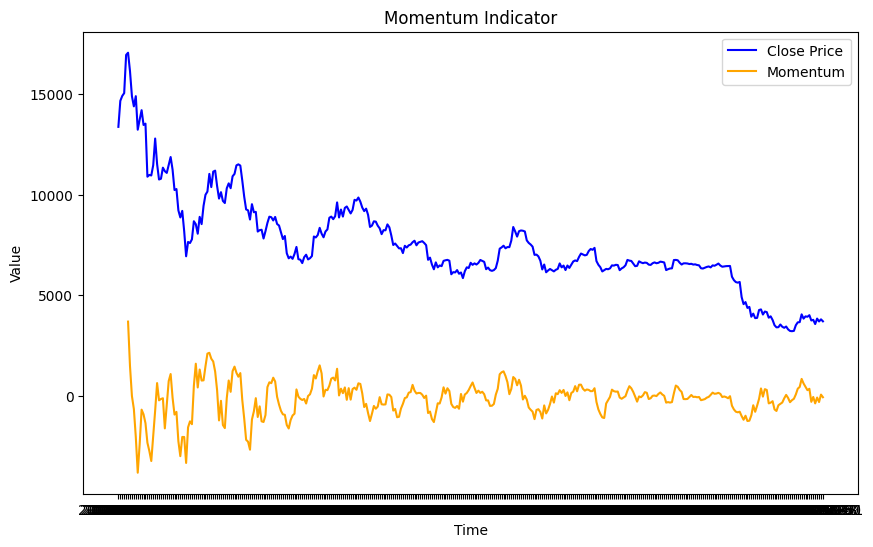

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from indicator.Momentum import Momentum

data = pd.read_csv('/workspace/BTCUSDT/BTCUSDT-1d-2018.csv', index_col=0)

momentum_result = Momentum(data, window=5)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(momentum_result['Momentum'], label='Momentum', color='orange')
plt.title('Momentum Indicator')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

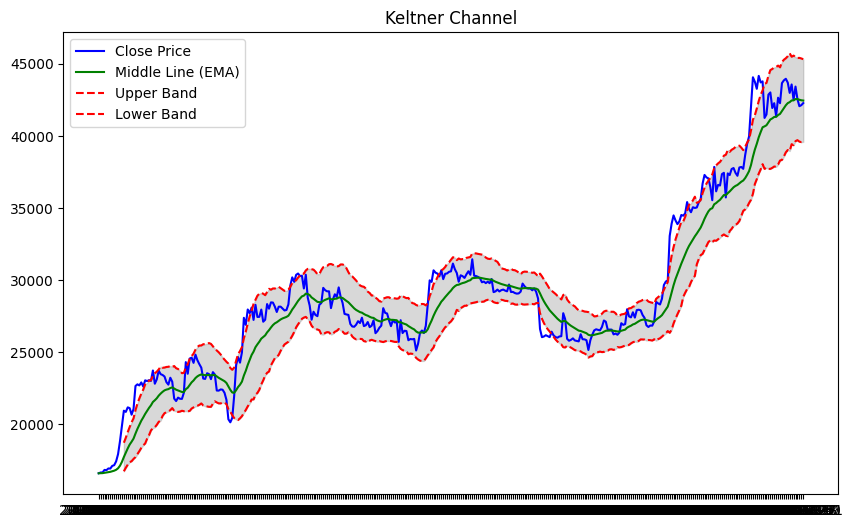

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
from indicator.KeltnerChannel import KeltnerChannel

data = pd.read_csv('/workspace/BTCUSDT/BTCUSDT-1d-2023.csv', index_col=0)
# 모멘텀 데이터 생성
keltner_channel = KeltnerChannel(data)

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(keltner_channel['Middle Line'], label='Middle Line (EMA)', color='green')
plt.plot(keltner_channel['Upper Band'], label='Upper Band', color='red', linestyle='--')
plt.plot(keltner_channel['Lower Band'], label='Lower Band', color='red', linestyle='--')
plt.fill_between(keltner_channel.index, 
                 keltner_channel['Upper Band'], 
                 keltner_channel['Lower Band'], 
                 color='grey', alpha=0.3)
plt.title('Keltner Channel')
plt.legend()
plt.show()


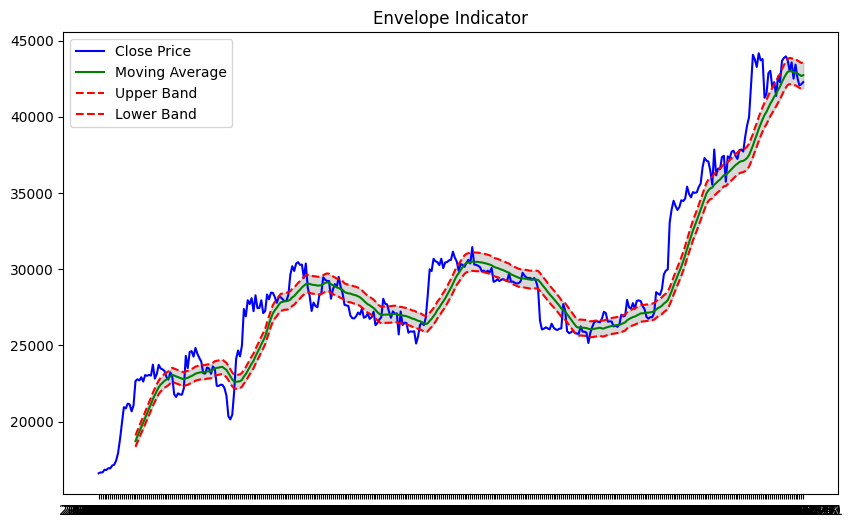

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from indicator.Envelope import Envelope

# Envelope 데이터 생성
envelope_result = Envelope(data, deviation=0.02, method='SMA')

# 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price', color='blue')
plt.plot(envelope_result['Moving Average'], label='Moving Average', color='green')
plt.plot(envelope_result['Upper Band'], label='Upper Band', color='red', linestyle='--')
plt.plot(envelope_result['Lower Band'], label='Lower Band', color='red', linestyle='--')
plt.fill_between(envelope_result.index, 
                 envelope_result['Upper Band'], 
                 envelope_result['Lower Band'], 
                 color='grey', alpha=0.3)
plt.title('Envelope Indicator')
plt.legend()
plt.show()

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

# 데이터셋 정의
class BitcoinDataset(Dataset):
    def __init__(self, data, seq_length=30):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.seq_length]
        target = self.data[idx + self.seq_length]['close']
        return torch.tensor(seq.values, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)


In [2]:
class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_layers, output_dim):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead), 
            num_layers=num_layers
        )
        self.fc = nn.Linear(d_model, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_length, input_dim)
        x = self.embedding(x)  # (batch_size, seq_length, d_model)
        x = x.permute(1, 0, 2)  # Transformer expects (seq_length, batch_size, d_model)
        x = self.transformer(x)
        x = x.mean(dim=0)  # Aggregate sequence output
        return self.fc(x)


In [6]:
class BitcoinTradingEnv:
    def __init__(self, data, initial_balance=1000):
        self.data = data
        self.initial_balance = initial_balance
        self.current_step = 0
        self.balance = initial_balance
        self.holdings = 0
        self.done = False

    def reset(self):
        self.current_step = 0
        self.balance = self.initial_balance
        self.holdings = 0
        self.done = False
        return self.data.iloc[self.current_step:self.current_step + 30].values

    def step(self, action):
        current_price = self.data.iloc[self.current_step]['Close']
        reward = 0

        if action == 1:  # 매수
            if self.balance > 0:
                self.holdings += self.balance / current_price
                self.balance = 0
        elif action == 2:  # 매도
            if self.holdings > 0:
                self.balance += self.holdings * current_price
                self.holdings = 0

        self.current_step += 1
        if self.current_step >= len(self.data) - 30:
            self.done = True
            reward = self.balance + self.holdings * current_price - self.initial_balance

        next_state = self.data.iloc[self.current_step:self.current_step + 30].values
        return next_state, reward, self.done


In [15]:
# 학습 함수 수정: 보상 및 정확도 기록
def train(env, model, optimizer, criterion, episodes=100):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    rewards = []  # 총 보상 기록
    accuracies = []  # 정확도 기록

    for episode in range(episodes):
        state = torch.tensor(env.reset(), dtype=torch.float32).to(device)
        total_reward = 0
        correct_actions = 0
        steps = 0

        while not env.done:
            state_tensor = state.unsqueeze(0)  # Add batch dimension
            logits = model(state_tensor)  # Get action probabilities
            action = torch.argmax(logits).item()  # Select the best action

            # Ground truth: 단순히 다음 가격이 상승(매수), 하락(매도) 판단 기준으로 정의
            current_price = env.data.iloc[env.current_step]['Close']
            next_price = env.data.iloc[env.current_step + 1]['Close'] if env.current_step + 1 < len(env.data) else current_price
            ground_truth = 1 if next_price > current_price else 2  # 상승: 1(매수), 하락: 2(매도)

            if action == ground_truth:
                correct_actions += 1

            next_state, reward, done = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32).to(device)

            loss = criterion(logits, torch.tensor([reward], dtype=torch.float32).to(device))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_reward += reward
            state = next_state
            steps += 1

        # 정확도 및 보상 기록
        accuracy = correct_actions / steps
        rewards.append(total_reward)
        accuracies.append(accuracy)

        print(f"Episode {episode + 1}/{episodes}, Total Reward: {total_reward:.2f}, Accuracy: {accuracy:.2f}")

    return rewards, accuracies

In [16]:
# 테스트 함수 수정: 보상 및 정확도 기록
def test(env, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    state = torch.tensor(env.reset(), dtype=torch.float32).to(device)
    total_reward = 0
    correct_actions = 0
    steps = 0

    while not env.done:
        state_tensor = state.unsqueeze(0)  # Add batch dimension
        with torch.no_grad():
            logits = model(state_tensor)
            action = torch.argmax(logits).item()

        current_price = env.data.iloc[env.current_step]['Close']
        next_price = env.data.iloc[env.current_step + 1]['Close'] if env.current_step + 1 < len(env.data) else current_price
        ground_truth = 1 if next_price > current_price else 2

        if action == ground_truth:
            correct_actions += 1

        next_state, reward, done = env.step(action)
        next_state = torch.tensor(next_state, dtype=torch.float32).to(device)

        total_reward += reward
        state = next_state
        steps += 1

    accuracy = correct_actions / steps
    print(f"Test completed in {steps} steps. Total Reward: {total_reward:.2f}, Accuracy: {accuracy:.2f}")
    return total_reward, accuracy

In [17]:
import matplotlib.pyplot as plt

# 학습 및 테스트 결과 시각화 함수
def plot_metrics(rewards, accuracies, test_reward, test_accuracy):
    plt.figure(figsize=(12, 6))

    # 보상 그래프
    plt.subplot(1, 2, 1)
    plt.plot(rewards, label='Training Reward')
    plt.axhline(test_reward, color='red', linestyle='--', label='Test Reward')
    plt.title('Rewards Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Training Accuracy')
    plt.axhline(test_accuracy, color='red', linestyle='--', label='Test Accuracy')
    plt.title('Accuracy Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Starting Training...
Episode 1/50, Total Reward: 195.63, Accuracy: 0.36
Episode 2/50, Total Reward: 544.48, Accuracy: 0.35
Episode 3/50, Total Reward: 173.89, Accuracy: 0.32
Episode 4/50, Total Reward: 216.93, Accuracy: 0.33
Episode 5/50, Total Reward: 323.89, Accuracy: 0.32
Episode 6/50, Total Reward: 295.58, Accuracy: 0.32
Episode 7/50, Total Reward: 601.15, Accuracy: 0.34
Episode 8/50, Total Reward: 614.07, Accuracy: 0.34
Episode 9/50, Total Reward: 677.03, Accuracy: 0.34
Episode 10/50, Total Reward: 405.29, Accuracy: 0.33
Episode 11/50, Total Reward: 129.78, Accuracy: 0.34
Episode 12/50, Total Reward: 644.32, Accuracy: 0.31
Episode 13/50, Total Reward: 88.37, Accuracy: 0.34
Episode 14/50, Total Reward: 523.13, Accuracy: 0.33
Episode 15/50, Total Reward: 345.85, Accuracy: 0.32
Episode 16/50, Total Reward: 107.73, Accuracy: 0.30
Episode 17/50, Total Reward: 405.19, Accuracy: 0.32
Episode 18/50, Total Reward: 15.25, Accuracy: 0.30
Episode 19/50, Total Reward: 674.24, Accuracy: 0.33
Ep

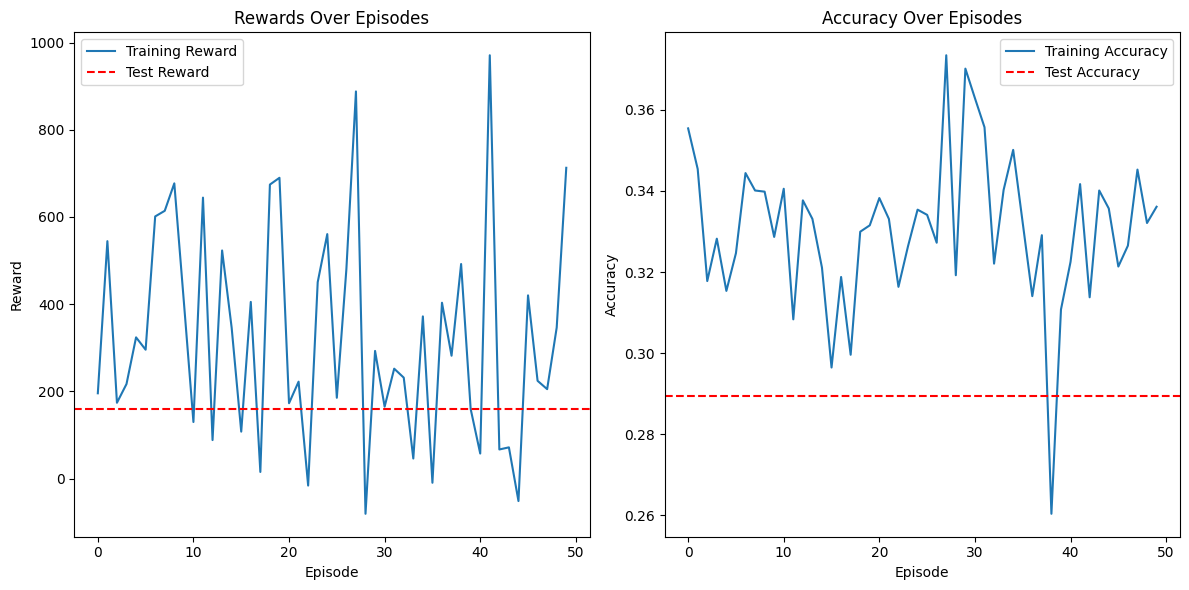

In [18]:
# 데이터 로드 및 분할
data = pd.read_csv('/workspace/BTCUSDT/BTCUSDT-1h-2023.csv', index_col=0)
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# 학습/테스트 데이터 분리
train_data = data.iloc[:int(len(data) * 0.8)]
test_data = data.iloc[int(len(data) * 0.8):]

# 학습 환경
train_env = BitcoinTradingEnv(train_data)

# 테스트 환경
test_env = BitcoinTradingEnv(test_data)

# 모델 초기화
model = TransformerModel(input_dim=5, d_model=64, nhead=4, num_layers=2, output_dim=3)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 학습
print("Starting Training...")
training_rewards, training_accuracies = train(train_env, model, optimizer, criterion, episodes=50)

# 테스트
print("\nStarting Testing...")
test_reward, test_accuracy = test(test_env, model)

# 결과 시각화
plot_metrics(training_rewards, training_accuracies, test_reward, test_accuracy)

In [ ]:
# 새로운 데이터 준비 (예: 학습하지 않은 최근 비트코인 데이터)
new_data = pd.read_csv("new_bitcoin_data.csv")
new_data = new_data[['Open', 'High', 'Low', 'Close', 'Volume']]

# 새로운 환경 생성
new_env = BitcoinTradingEnv(new_data)

# 기존 옵티마이저를 재사용하거나 새로 초기화
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # 낮은 학습률 추천
criterion = nn.MSELoss()

# 추가 학습 수행
print("Starting Fine-Tuning...")
train(new_env, model, optimizer, criterion, episodes=10)  # 적절한 에피소드 수로 조정

In [35]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 간단한 환경 정의
class BitcoinTradingEnv:
    def __init__(self, data):
        self.data = data.reset_index(drop=True)
        self.current_step = 0
        self.balance = 10000  # 초기 자산
        self.position = 0    # 현재 보유한 포지션 (1: 매수, -1: 매도, 0: 없음)
        self.done = False

    def reset(self):
        self.current_step = 0
        self.balance = 10000
        self.position = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        return self.data.iloc[self.current_step].values

    def step(self, action):
        # action: 0=관망, 1=매수, 2=매도
        current_price = self.data.iloc[self.current_step]['Close']
        reward = 0

        if action == 1 and self.position == 0:  # 매수
            self.position = 1
            self.entry_price = current_price
        elif action == 2 and self.position == 0:  # 매도
            self.position = -1
            self.entry_price = current_price
        elif action == 0 and self.position != 0:  # 포지션 청산
            profit = (current_price - self.entry_price) * self.position
            reward = profit
            self.balance += profit
            self.position = 0

        self.current_step += 1
        if self.current_step >= len(self.data) - 1:
            self.done = True

        next_state = self._get_state()
        return next_state, reward, self.done

# Actor-Critic 모델 정의
class ActorCritic(nn.Module):
    def __init__(self, input_dim, hidden_dim, action_dim):
        super(ActorCritic, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, state):
        action_probs = self.actor(state)
        state_value = self.critic(state)
        return action_probs, state_value
